In [ ]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.7.0


In [ ]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# Download historical data. I am using https://finance.yahoo.com/ . 
# This data contains daily stock prices for Starbucks from about February 2018 to February 2019
df = pd.read_csv('SBUX.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-16,60.330002,61.099998,60.299999,60.560001,55.997318,8040700
1,2018-01-17,61.000000,61.330002,60.520000,60.660000,56.089783,8433800
2,2018-01-18,61.430000,61.439999,60.740002,61.090000,56.487389,9170900
3,2018-01-19,61.209999,61.459999,60.950001,61.259998,56.644581,8361900
4,2018-01-22,61.040001,61.470001,60.770000,61.410000,56.783276,11945800


In [ ]:
# Rename columns
df.rename(columns={"Date":"date","Open":"open","High":"high","Low":"low","Close":"close","Volume":"volume"}, inplace= True)
df.head()

,date,open,high,low,close,Adj Close,volume
0,2018-01-16,60.330002,61.099998,60.299999,60.560001,55.997318,8040700
1,2018-01-17,61.000000,61.330002,60.520000,60.660000,56.089783,8433800
2,2018-01-18,61.430000,61.439999,60.740002,61.090000,56.487389,9170900
3,2018-01-19,61.209999,61.459999,60.950001,61.259998,56.644581,8361900
4,2018-01-22,61.040001,61.470001,60.770000,61.410000,56.783276,11945800


In [ ]:
df.tail()

,date,open,high,low,close,Adj Close,volume
245,2019-01-07,63.349998,64.239998,62.740002,63.570000,60.143196,10337600
246,2019-01-08,63.939999,64.290001,63.049999,63.619999,60.190495,10809700
247,2019-01-09,63.650002,64.040001,62.950001,63.880001,60.436481,13080300
248,2019-01-10,63.610001,64.389999,63.240002,64.190002,60.729774,10397600
249,2019-01-11,62.290001,63.840000,61.669998,63.730000,60.294563,13805700


#**Naïve Approach**
####Try to predict stock price using one variable. Which is closing price.

In [ ]:
series = df['close'].values.reshape(-1, 1)

In [ ]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
### build the dataset
# Let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (240, 10, 1) Y.shape (240,)


###Build the model

In [ ]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
4/4 [==============================] - 3s 181ms/step - loss: 0.4656 - val_loss: 2.9954
Epoch 2/80
4/4 [==============================] - 0s 11ms/step - loss: 0.2007 - val_loss: 2.9651
Epoch 3/80
4/4 [==============================] - 0s 15ms/step - loss: 0.1298 - val_loss: 2.4594
Epoch 4/80
4/4 [==============================] - 0s 11ms/step - loss: 0.1288 - val_loss: 2.5852
Epoch 5/80
4/4 [==============================] - 0s 13ms/step - loss: 0.1099 - val_loss: 2.1760
Epoch 6/80
4/4 [==============================] - 0s 11ms/step - loss: 0.0987 - val_loss: 2.2066
Epoch 7/80
4/4 [==============================] - 0s 15ms/step - loss: 0.0922 - val_loss: 2.3754
Epoch 8/80
4/4 [==============================] - 0s 11ms/step - loss: 0.0887 - val_loss: 2.2728
Epoch 9/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0850 - val_loss: 2.2490
Epoch 10/80
4/4 [==============================] - 0s 11ms/step - loss: 0.0840 - val_loss: 2.2687
Epoch 11/80
4/4 [===========

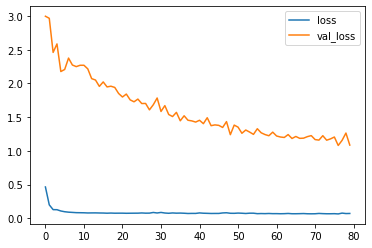

In [ ]:
# Plot loss per epoch
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### One-step forecast using true targets

(240, 1)


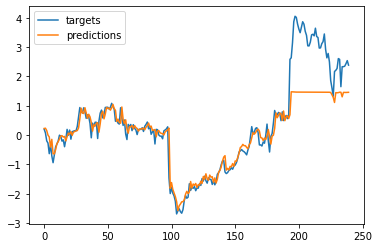

In [ ]:

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

So we can see that the loss does decrease which is promising. That means our Elysium network can indeed predict somewhere close to the next value in the time series. 

### Multi-step forecast

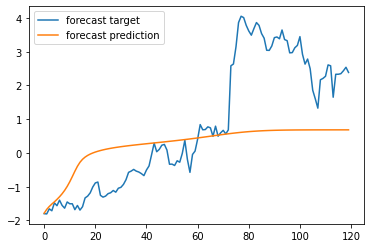

In [ ]:

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

When we do a multi-step forecast, all we see is a pretty straight line, it means the model isn't really predicting the next value in the time series, it's just copying the previous value. And that actually makes a lot of sense for a time series. This time series is probably a smooth function over time and we can see that that's exactly the model we've created. So it this model is not really doing much. 

# **More Rational Approach**
### Try to predict stock return using one variable instead of stock price


In [ ]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [ ]:
df.head()

,date,open,high,low,close,Adj Close,volume,PrevClose
0,2018-01-16,60.330002,61.099998,60.299999,60.560001,55.997318,8040700,NaN
1,2018-01-17,61.000000,61.330002,60.520000,60.660000,56.089783,8433800,60.560001
2,2018-01-18,61.430000,61.439999,60.740002,61.090000,56.487389,9170900,60.660000
3,2018-01-19,61.209999,61.459999,60.950001,61.259998,56.644581,8361900,61.090000
4,2018-01-22,61.040001,61.470001,60.770000,61.410000,56.783276,11945800,61.259998


In [ ]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,Adj Close,volume,PrevClose,Return
0,2018-01-16,60.330002,61.099998,60.299999,60.560001,55.997318,8040700,NaN,NaN
1,2018-01-17,61.000000,61.330002,60.520000,60.660000,56.089783,8433800,60.560001,0.001651
2,2018-01-18,61.430000,61.439999,60.740002,61.090000,56.487389,9170900,60.660000,0.007089
3,2018-01-19,61.209999,61.459999,60.950001,61.259998,56.644581,8361900,61.090000,0.002783
4,2018-01-22,61.040001,61.470001,60.770000,61.410000,56.783276,11945800,61.259998,0.002449


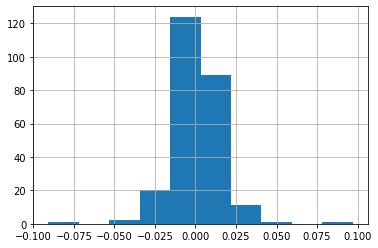

In [ ]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [ ]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (239, 10, 1) Y.shape (239,)


In [ ]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
4/4 [==============================] - 2s 127ms/step - loss: 0.9671 - val_loss: 1.0412
Epoch 2/80
4/4 [==============================] - 0s 12ms/step - loss: 0.9621 - val_loss: 1.0522
Epoch 3/80
4/4 [==============================] - 0s 17ms/step - loss: 0.9596 - val_loss: 1.0553
Epoch 4/80
4/4 [==============================] - 0s 12ms/step - loss: 0.9571 - val_loss: 1.0674
Epoch 5/80
4/4 [==============================] - 0s 11ms/step - loss: 0.9564 - val_loss: 1.0704
Epoch 6/80
4/4 [==============================] - 0s 15ms/step - loss: 0.9543 - val_loss: 1.0727
Epoch 7/80
4/4 [==============================] - 0s 11ms/step - loss: 0.9526 - val_loss: 1.0705
Epoch 8/80
4/4 [==============================] - 0s 15ms/step - loss: 0.9503 - val_loss: 1.0681
Epoch 9/80
4/4 [==============================] - 0s 11ms/step - loss: 0.9495 - val_loss: 1.0658
Epoch 10/80
4/4 [==============================] - 0s 15ms/step - loss: 0.9469 - val_loss: 1.0689
Epoch 11/80
4/4 [===========

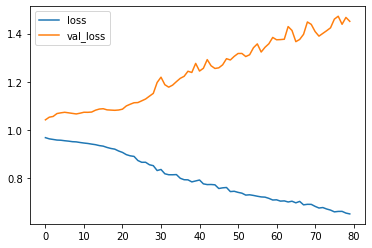

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

What we can see from this is that the model has a much harder time learning anything. It looks like the loss goes down a tiny bit but only at the cost of the validation lost going up. In other words it's just fitting to the noise next we're going to do a once that forecast and so here are the results. 

### One-step forecast

(239, 1)


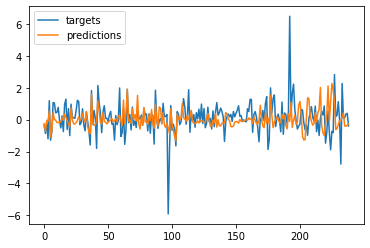

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

### Multi-step forecast

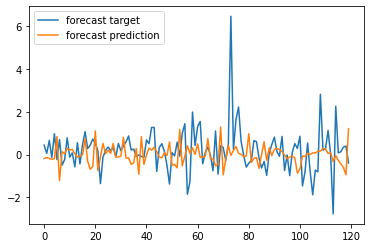

In [ ]:

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

So here are the results for the multi-step again. We have the situation where the model isn't really able to do much except copy the same value over and over again.

# Testing the fundamentals of stock price prediction using historical dataset
###Try to predict stock direction using multiple variables


In [ ]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [ ]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [ ]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
6/6 [==============================] - 2s 86ms/step - loss: 0.6907 - accuracy: 0.5542 - val_loss: 0.6998 - val_accuracy: 0.4865
Epoch 2/300
6/6 [==============================] - 0s 9ms/step - loss: 0.6831 - accuracy: 0.5482 - val_loss: 0.7217 - val_accuracy: 0.4595
Epoch 3/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6830 - accuracy: 0.5301 - val_loss: 0.7510 - val_accuracy: 0.4595
Epoch 4/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6797 - accuracy: 0.5482 - val_loss: 0.7548 - val_accuracy: 0.4595
Epoch 5/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6761 - accuracy: 0.5482 - val_loss: 0.7588 - val_accuracy: 0.4595
Epoch 6/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6736 - accuracy: 0.5723 - val_loss: 0.7504 - val_accuracy: 0.5000
Epoch 7/300
6/6 [==============================] - 0s 9ms/step - loss: 0.6721 - accuracy: 0.5904 - val_loss: 0.7341 - val_accuracy: 0.4730
Epoch 8/300
6/6 [=========

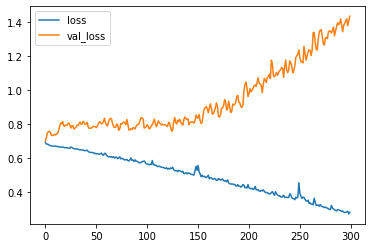

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

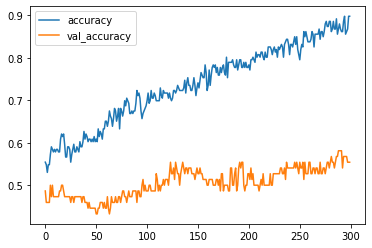

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## **Conclusion**

**Approach one**: In the first example I used an LSTM to predict future stock prices from past stock prices. While this appeared to work well with the one-step forecast but it didn't work so well for multi-step forecasts. The model was likely just remembering the previous value and making that prediction.

**Approach two**: I tried to predict stock return. In this example I saw that I couldn't get the loss to decrease that much.

**Approach three**: The third example I considered all the data not just the previous closed prices and to turn our model into a binary classifier. We saw that even on the simplest possible task with the most data the models still could not achieve better results than random guessing what this tells us is that there isn't any hope of our first two models working in the first place. Imagine if you can't even predict whether the stock price will go up or down. How could you ever predict the numerical value of the return or the next stock price itself.

The major problem with trying to predict stock prices from only historical stock prices is that it's a fundamentally flawed approach. These approaches don't take into account data about the world itself.  Many times it's due to some occurrence in the real world.